In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys
# sys.path.insert(0, '../libraries/')
# sys.path.insert(0, '../../BNP_modeling/')

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
import bnpgmm_runjingdev.simulation_lib as simulation_lib


import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import json 

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


# Load data

We load and plot the iris dataset

In [2]:
use_iris_data = True

In [3]:
if use_iris_data: 
    # load iris data
    dataset_name = 'iris'
    features, iris_species = utils_lib.load_data()
    dim = features.shape[1]
    n_obs = len(iris_species)    
else: 
    dim = 4
    n_obs = 500
    true_k = 4
    features, true_z = simulation_lib.simulate_data(n_obs, dim,
                true_k, separation=0.2)[0:2]
    
    iris_species = np.argmax(true_z, 1)

Text(0, 0.5, 'PC2')

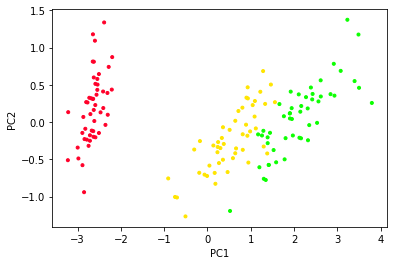

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [5]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

print(prior_params_dict)

{'alpha': array([3.]), 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


### Variational parameters

In [6]:
# number of clusters in variational distribution 
k_approx = 30

In [7]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [8]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [9]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1731.7713604176683

# Optimize the KL objective

### Initialize with k-means

In [10]:
run_kmeans_init = True

In [11]:
if run_kmeans_init: 
    # run a kmeans init
    n_kmeans_init = 10
    init_vb_free_params, init_vb_params_dict, init_ez = \
        utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                    n_kmeans_init = n_kmeans_init, 
                                                  seed = 344353)
else: 
    init_vb_params_dict = vb_params_paragami.random()
    init_vb_free_params = vb_params_paragami.flatten(init_vb_params_dict, free = True)

In [12]:
print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
8171.585100596154


In [13]:
vb_params_dict = deepcopy(init_vb_params_dict)

In [14]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_loss = lambda x : get_vb_params_loss(features, x, prior_params_dict,
                                         gh_loc, gh_weights)


### Optimize using Newton

In [15]:
vb_opt = optimization_lib.optimize_full(get_loss, init_vb_free_params,
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
Iter 0: f = 8171.58510060
Iter 1: f = 6581.63639852
Iter 2: f = 5376.95556216
Iter 3: f = 4572.68192908
Iter 4: f = 4179.85777135
Iter 5: f = 3842.43843338
Iter 6: f = 3934.22127474
Iter 7: f = 3717.66487829
Iter 8: f = 3536.87328304
Iter 9: f = 3377.87156472
Iter 10: f = 3286.57717255
Iter 11: f = 3134.29627817
Iter 12: f = 2949.47392038
Iter 13: f = 2678.26536356
Iter 14: f = 2329.14325291
Iter 15: f = 2044.59657786
Iter 16: f = 1763.69919621
Iter 17: f = 1465.98270130
Iter 18: f = 1732.47163211
Iter 19: f = 1385.06588967
Iter 20: f = 1246.72346594
Iter 21: f = 1079.22610965
Iter 22: f = 821.76693225
Iter 23: f = 653.45191998
Iter 24: f = 553.33351819
Iter 25: f = 679.40808397
Iter 26: f = 519.05372453
Iter 27: f = 460.28742084
Iter 28: f = 375.19119530
Iter 29: f = 338.84808749
Iter 30: f = 283.51755234
Iter 31: f = 224.91390078
Iter 32: f = 149.88012193
Iter 33: f = 90.42852145
Iter 34: f = 126.07830962
Iter 35: f = 66.64940290
Iter 36: f = 36.73684234
Iter 37: f 

Iter 297: f = -376.48307001
Iter 298: f = -376.50070713
Iter 299: f = -376.50312056
Iter 300: f = -376.50730725
Iter 301: f = -376.51443122
Iter 302: f = -376.52089033
Iter 303: f = -376.52753727
Iter 304: f = -376.53168162
Iter 305: f = -376.53788132
Iter 306: f = -376.53973913
Iter 307: f = -376.54310994
Iter 308: f = -376.54878481
Iter 309: f = -376.54943927
Iter 310: f = -376.55068705
Iter 311: f = -376.55290140
Iter 312: f = -376.55655164
Iter 313: f = -376.55733777
Iter 314: f = -376.55878986
Iter 315: f = -376.56135690
Iter 316: f = -376.56427497
Iter 317: f = -376.56673759
Iter 318: f = -376.56760984
Iter 319: f = -376.56926604
Iter 320: f = -376.57223607
Iter 321: f = -376.57744126
Iter 322: f = -376.58634411
Iter 323: f = -376.59697426
Iter 324: f = -376.60468640
Iter 325: f = -376.61499346
Iter 326: f = -376.63267597
Iter 327: f = -376.64831633
Iter 328: f = -376.67255139
Iter 329: f = -376.68450166
Iter 330: f = -376.70210089
Iter 331: f = -376.71436219
Iter 332: f = -376.7

In [16]:
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)

In [17]:
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict,
                                                    gh_loc, gh_weights)

# Check out results from Newton

In [18]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, 
                        vb_params_dict['cluster_params']['centroids'], 
                        np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))

    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

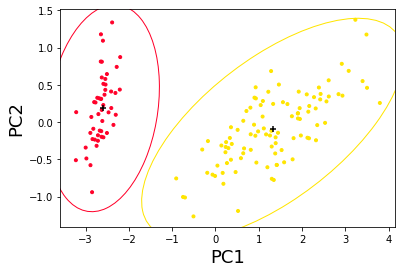

In [19]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Check out CAVI optimizer

In [20]:
vb_params_dict = deepcopy(init_vb_params_dict)

# vb_params_dict = vb_params_paragami.random()

Text(0, 0.5, 'PC2')

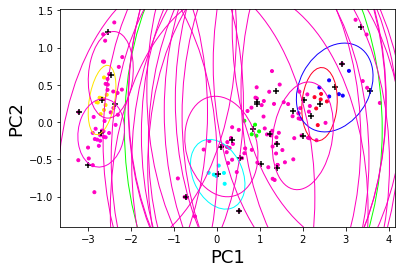

In [21]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, init_vb_params_dict, init_ez, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [22]:
import time

In [23]:
vb_cavi_dict, e_z_cavi, kl_vec = \
    cavi_lib.run_cavi(features, vb_params_dict,
                vb_params_paragami,
                prior_params_dict,
                gh_loc, gh_weights,
                max_iter = 1000,
                tol = 1e-8,
                debug = False)

done. num iterations = 124
stick_time: 1.203sec
cluster_time: 0.114sec
e_z_time: 0.343sec
**TOTAL time: 2.235sec**


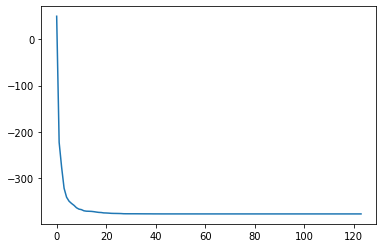

In [24]:
plt.plot(kl_vec)

In [25]:
kl_vec.mean()

-370.2307398981513

Text(0, 0.5, 'PC2')

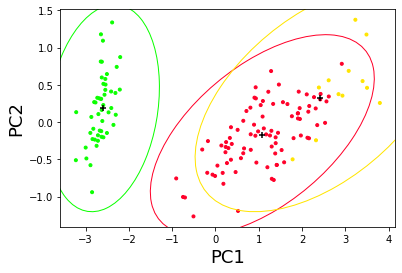

In [26]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_cavi_dict, e_z_cavi, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [27]:
get_loss(vb_params_paragami.flatten(vb_cavi_dict, free = True))

-377.7428353718093

In [28]:
get_loss(vb_params_paragami.flatten(vb_opt_dict, free = True))

-377.25253927654353

# Run newton after CAVI

In [29]:
vb_opt2 = optimization_lib.optimize_full(get_loss, 
                    vb_params_paragami.flatten(deepcopy(vb_cavi_dict), free = True),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
Iter 0: f = -377.74283537
Iter 1: f = -377.74247339
Iter 2: f = -377.74283538
Iter 3: f = -377.74283538
Iter 4: f = -377.74283539
Iter 5: f = -377.74283540
Iter 6: f = -377.74283540
Iter 7: f = -377.74283540
Iter 8: f = -377.74283540
Iter 9: f = -377.74283540
Iter 10: f = -377.74283541
Iter 11: f = -377.74283542
Iter 12: f = -377.74283543
Iter 13: f = -377.74283548
Iter 14: f = -377.74283557
Iter 15: f = -377.74283564
Iter 16: f = -377.74283569
Iter 17: f = -377.74283512
Iter 18: f = -377.74283570
Iter 19: f = -377.74283571
Iter 20: f = -377.74283571
Iter 21: f = -377.74283572
Iter 22: f = -377.74283573
Iter 23: f = -377.74283575
Iter 24: f = -377.74283575
Iter 25: f = -377.74283576
Iter 26: f = -377.74283577
Iter 27: f = -377.74283577
Iter 28: f = -377.74283577
Iter 29: f = -377.74283578
Iter 30: f = -377.74283578
Iter 31: f = -377.74283578
Iter 32: f = -377.74283578
Iter 33: f = -377.74283578
Iter 34: f = -377.74283579
Iter 35: f = -377.74283579
Iter 36: f = -377.74

In [30]:
np.abs(vb_opt2 - vb_params_paragami.flatten(vb_cavi_dict, free = True)).max()

0.0010668305255198962